In [1]:
import numpy as np
import fiducial as fid
import matplotlib.pyplot as plt
import utils as u
import Eg_cov as egcov
import joint_cov as jp
import pyccl.nl_pt as pt

Check what happens when you use a nonlinear galaxy bias to the linear scale cuts.

Set up parameters etc

In [2]:
lens = 'DESI'
src = 'LSST'

Pimax=900.
#rp_bin_edges = np.logspace(np.log10(rp0), np.log10(50.), 11)
endfilename='_Mar25'
#rp_bin_c = u.rp_bins_mid(rp_bin_edges)
# Let's use the same cosmological parameters as Shadab's simulations:
h=0.69
OmB = 0.022/h**2

# Using now nonlinear bias parameters as fit in Kitanis & White 2022. 
# They fit LTP parameters so we convert these to their Eulerian equivalents.
b1_LPT = 1.333
b2_LPT = 0.514
bs_LPT = 0 # They fix this to 0.

# Convert to Eulerian using the conversions in Chen, Vlah & White 2020 (these use the same convention as Kitanis & White 2022)
b1 = 1.0 + b1_LPT
b2 = b2_LPT + 8./21.*(b1_LPT)
bs = bs_LPT - 2./7*(b1_LPT)

#b1 = 2.03
#b2 = 0.9*(b1-1.0)**2-0.5 # From Fast-PT example notebook which says 
#'(this is a numerical fit to simulation k2Pnl1_regdata, but a relationship of this form is motivated in the spherical collapse picture'
#bs = -4.0/7.0*(b1-1.0) # The 'coevolution value' see Pandey et al. DES Y3 papers

params = {'mu_0': 0., 'sigma_0':0., 'OmB':OmB, 'h':h, 'n_s':0.965, 'A_s':2.115 * 10**(-9),'b':b1, 'OmM': 0.292, 'b_2':b2, 'b_s': bs} 

#Nsamps=100000

print('b1=', b1)
print('b2=', b2)
print('bs=', bs)


b1= 2.333
b2= 1.021809523809524
bs= -0.38085714285714284


In [4]:
rp0 = 1.5

rp_bin_c_raw = np.loadtxt('../data_for_Danielle/test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
rp_bin_edges_raw = u.rp_bin_edges_log(rp_bin_c_raw)
#Cut below rp0 making sure rp0 is in the lowest bin. Go one bin lower because this 
ind = next(j[0] for j in enumerate(rp_bin_edges_raw) if j[1]>rp0)
rp_bin_c = rp_bin_c_raw[ind:][4:]
rp_bin_edges = rp_bin_edges_raw[ind:][4:]

print('rp bin c=', rp_bin_c)
print('rp bin edges=', rp_bin_edges)

rp bin c= [ 5.54793718  7.31360558  9.64120984 12.70958983 16.75450244 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]
rp bin edges= [  4.83205129   6.36988417   8.39714273  11.06958999  14.5925616   19.23674266  25.35896564  33.42962733  44.0688315   58.09403408  76.5828519  100.95586057]


Get data covariance matrices for E_G and the joint probes case.

In [5]:
#Dcov_jp = jp.get_joint_covariance(params, lens, src, rp_bin_edges, rp_bin_c, rp0, endfilename)
#np.savetxt('/home/danielle/Documents/CMU/Research/EG_comparison/txtfiles/Dcov_jp_'+endfilename+'.txt', Dcov_jp)
#Dcov_jp = np.loadtxt('../txtfiles/joint_covariance_rp0=1.5_Jul2025.dat')
Dcov_jp_raw = np.loadtxt('../txtfiles/joint_covariance_rp0=1.5_Jul2025.dat')
#Dcov_jp_raw = np.loadtxt('../txtfiles/joint_covariance_rp0=1.5_Jul2025_LSSTY10.dat')

Dcov_jp = np.delete(np.delete(Dcov_jp_raw, [0,1,2,3,15,16,17,18], axis=0), [0,1,2,3,15,16,17,18], axis=1)

print(Dcov_jp.shape)

(23, 23)


In [6]:
#Dcov_eg = egcov.get_egcov(params, rp_bin_edges, rp_bin_c, rp0, lens, src, Pimax, Nsamps, endfilename)
#np.savetxt('/home/danielle/Documents/CMU/Research/EG_comparison/txtfiles/Dcov_eg_'+endfilename+'.txt', Dcov_eg)
Dcov_eg_raw = np.loadtxt('../txtfiles/eg_cov_Y1.dat')
#Dcov_eg_raw = np.loadtxt('../txtfiles/eg_cov_Y10.dat')

Dcov_eg = Dcov_eg_raw[4:,4:]

print(Dcov_eg.shape)

(11, 11)


Get the linear and nonlinear datavector for E_G

In [7]:
# Get linear datavector
data_lin_EG = fid.E_G(params, rp_bin_edges, rp0, lens, src, Pimax, endfilename, nonlin=False)
# Get nonlinear datavector
data_nl_EG = fid.E_G(params, rp_bin_edges, rp0, lens, src, Pimax, endfilename, nonlin=True, nl_bias=True)

getting Upgg
getting Upgm
maxchi= 6669.353003473356
getting Upgg
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
getting Upgm
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356


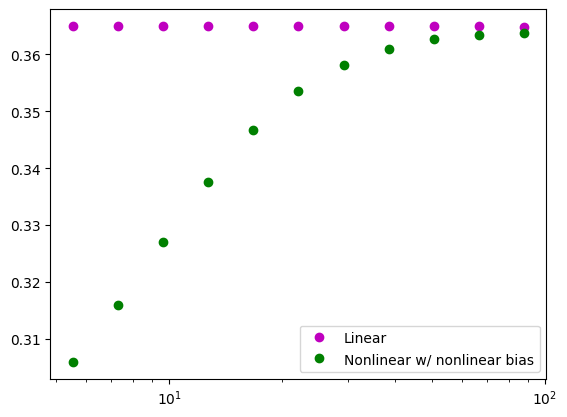

In [8]:
plt.figure()
plt.semilogx(rp_bin_c, data_lin_EG, 'mo', label='Linear')
plt.semilogx(rp_bin_c, data_nl_EG, 'go', label='Nonlinear w/ nonlinear bias')
plt.legend()
plt.show()

Get scale cuts for Eg

In [9]:
cut_inds_Eg = u.linear_scale_cuts_hartlap(data_nl_EG, data_lin_EG, Dcov_eg, rp_bin_c, covsamps=100)

chi2_temp= [49.40595682 53.04730892 56.60737616 60.65754163 61.76536993 61.71262101 61.62261526 61.68382281 61.74431107 61.77559896 61.7528866 ]
ind_min= 0
chi2_temp= [33.17516622 43.39951456 48.57849478 49.89198345 49.90382841 49.81625795 49.8895258  49.95597214 49.96703634 49.95611217]
ind_min= 0
chi2_temp= [18.06123685 30.80895229 33.41079259 33.54608311 33.39108734 33.48555427 33.54757376 33.53768109 33.54719138]
ind_min= 0
chi2_temp= [ 8.12130922 17.62009739 18.26081978 18.17312884 18.24125049 18.25260163 18.25853804 18.26191509]
ind_min= 0
chi2_temp= [2.90525571 8.16376653 8.15698625 8.19386953 8.20772432 8.20785361 8.20887152]
ind_min= 0
chi2_temp= [0.83134099 2.92575097 2.91660309 2.93620095 2.93400124 2.93410887]
ind_min= 0
ex_inds= [0, 1, 2, 3, 4, 5]


In [10]:
print("cut indices=", cut_inds_Eg)

cut indices= [0, 1, 2, 3, 4, 5]


Now get the linear and nonlinear data vectors for the joint probes case

In [11]:
data_lin_jp = fid.jp_datavector(params, rp_bin_edges, rp0, lens,src, Pimax, endfilename, nonlin = False)
data_nl_jp = fid.jp_datavector(params, rp_bin_edges, rp0, lens,src, Pimax, endfilename, nonlin = True, nl_bias=True)

maxchi= 6669.353003473356
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
Warning, you selected a extrap_high that is less than k_max. Therefore no extrapolation will be done.
maxchi= 6669.353003473356


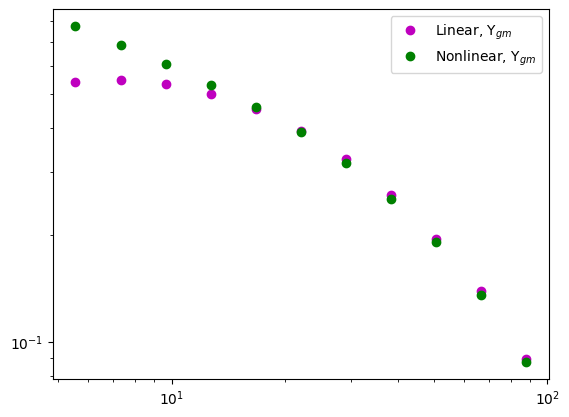

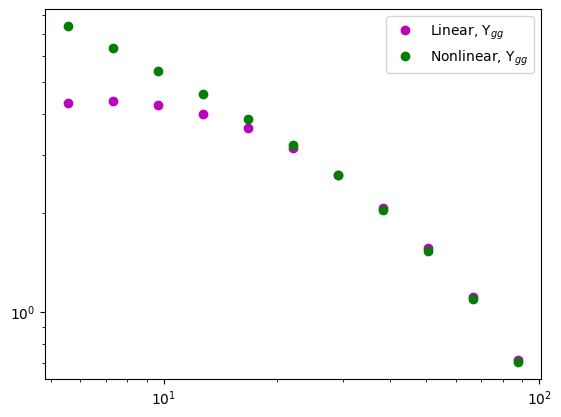

beta, lin= 0.342906677696308
beta, nl= 0.342906677696308


In [12]:
plt.figure()
plt.loglog(rp_bin_c, data_lin_jp[0:len(rp_bin_c)], 'mo', label='Linear, $\\Upsilon_{gm}$')
plt.loglog(rp_bin_c, data_nl_jp[0:len(rp_bin_c)], 'go', label='Nonlinear, $\\Upsilon_{gm}$')
plt.legend()
plt.show()

plt.figure()
plt.loglog(rp_bin_c, data_lin_jp[len(rp_bin_c):2*len(rp_bin_c)], 'mo', label='Linear, $\\Upsilon_{gg}$')
plt.loglog(rp_bin_c, data_nl_jp[len(rp_bin_c):2*len(rp_bin_c)], 'go', label='Nonlinear, $\\Upsilon_{gg}$')
plt.legend()
plt.show()

# Check that beta is the same in the linear or nonlinear case
print("beta, lin=", data_lin_jp[-1])
print("beta, nl=", data_nl_jp[-1])

In [13]:
cut_inds_jp = u.linear_scale_cuts_hartlap(data_nl_jp, data_lin_jp, Dcov_jp, rp_bin_c, covsamps=100)

chi2_temp= [1665.63436822 1762.9174555  1773.14069724 1771.85450084 1771.93187796 1772.84031594 1773.12584294 1773.15792648 1773.15893713 1773.15925508 1773.15725273 1067.05951345 1654.40882888 1757.75573455 1773.15224729 1772.14268823 1772.71108567
 1773.10105815 1773.15718398 1773.15940191 1773.15824415 1773.1582952  1773.15941239]
ind_min= 11
chi2_temp= [ 893.46184361 1070.03842475 1081.03071645 1079.18125529 1079.60104961 1080.74311356 1081.06529026 1081.09833819 1081.09923245 1081.09962511 1081.09692703  671.15198349 1050.64335587 1080.75397641 1080.2065431  1080.62434176 1081.03547984
 1081.09731147 1081.09976835 1081.09847104 1081.09798898 1081.0997702 ]
ind_min= 11
chi2_temp= [464.5318565  639.71302012 679.78330676 676.700762   677.88930352 679.43798081 679.83118478 679.86688464 679.86767528 679.86810186 679.86493393 498.50819986 677.26120689 679.34489117 679.37689404 679.79611534 679.86542368 679.86824248
 679.86688327 679.86605837 679.86824301]
ind_min= 0
chi2_temp= [360.9002

In [14]:
print("cut indices=", cut_inds_jp)

cut indices= [0, 1, 2, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16]


For joint probes, we disect this to find the elements to cut for individual probes.

In [15]:
cut_indices_gm = [ind for ind in cut_inds_jp if ind<len(rp_bin_c)]
ind_keep_gm = [ind for ind in range(0,len(rp_bin_c)) if ind not in cut_indices_gm]
rp_keep_gm = rp_bin_c[ind_keep_gm]
Ups_keep_gm = data_nl_jp[ind_keep_gm]
print(zip(rp_keep_gm, Ups_keep_gm))

cut_indices_gg = [(ind-len(rp_bin_c)) for ind in cut_inds_jp if ind>=len(rp_bin_c)]
ind_keep_gg = [ind for ind in range(0,len(rp_bin_c)) if ind not in cut_indices_gg]
ind_keep_gg_dvec = [ind+len(rp_bin_c) for ind in range(0,len(rp_bin_c)) if ind not in cut_indices_gg]
rp_keep_gg = rp_bin_c[ind_keep_gg]
Ups_keep_gg = data_nl_jp[ind_keep_gg_dvec]
print(zip(rp_keep_gg, Ups_keep_gg))

ind_keep_Eg = [ind for ind in range(0,len(rp_bin_c)) if ind not in cut_inds_Eg]
rp_keep_Eg = rp_bin_c[ind_keep_Eg]
Eg_keep = data_nl_EG[ind_keep_Eg]

Plot the data points this tells us to keep for joint probes (not many)

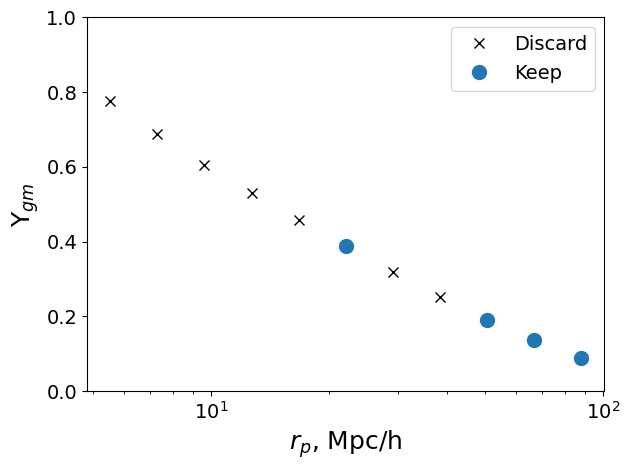

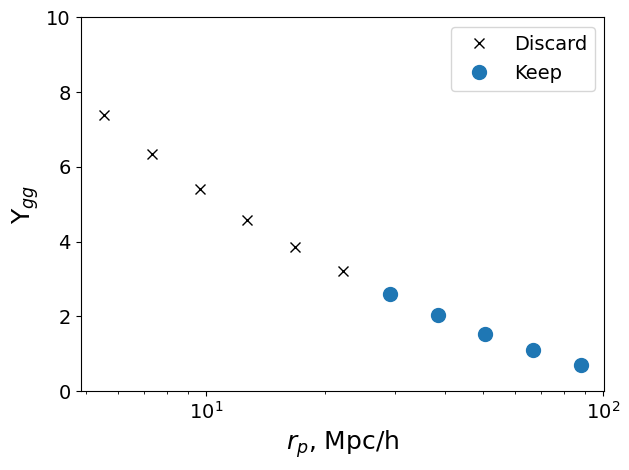

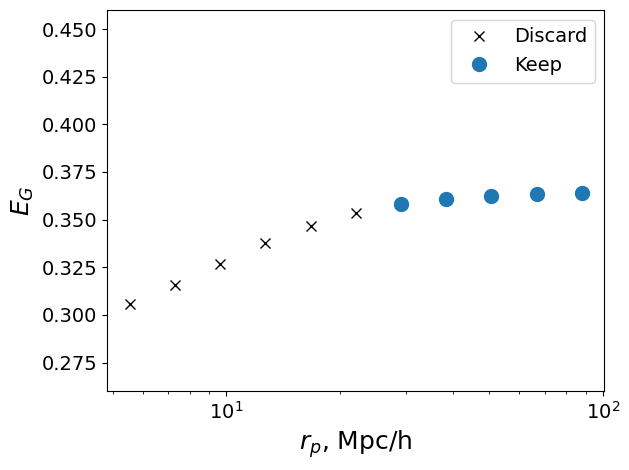

In [16]:
plt.figure()
plt.semilogx(rp_bin_c, data_nl_jp[0:len(rp_bin_c)], 'kx', markersize='7',label='Discard')
plt.semilogx(rp_keep_gm, Ups_keep_gm, 'o', markersize='10',label='Keep')
plt.ylabel('$\\Upsilon_{gm}$',fontsize=18)
plt.xlabel('$r_p$, Mpc/h', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0,1.0)
plt.tight_layout()
#plt.savefig('../plots/Upsilon_gm_linearscales_nLbias_KitanisWhite2022_wHartlap_Mar2025.pdf')
plt.show()

plt.figure()
plt.semilogx(rp_bin_c, data_nl_jp[len(rp_bin_c):2*len(rp_bin_c)], 'kx', markersize='7',label='Discard')
plt.semilogx(rp_keep_gg, Ups_keep_gg, 'o', markersize='10', label='Keep')
plt.ylabel('$\\Upsilon_{gg}$',fontsize=18)
plt.xlabel('$r_p$, Mpc/h',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0,10)
plt.tight_layout()
#plt.savefig('../plots/Upsilon_gg_linearscales_nLbias_KitanisWhite2022_wHartlap_Mar2025.pdf')
#plt.show()
#plt.savefig('../plots/Upsilon_gg_scales.png')

plt.figure()
plt.semilogx(rp_bin_c, data_nl_EG, 'kx', markersize='7',label='Discard')
plt.semilogx(rp_keep_Eg, Eg_keep, 'o', markersize='10',label='Keep')
plt.ylabel('$E_G$',fontsize=18)
plt.xlabel('$r_p$, Mpc/h',fontsize=18)
plt.ylim(0.26,0.46)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('../plots/EG_linearscales_nLbias_KitanisWhite2022_wHartlap_Mar2025.pdf')
#plt.show()

In [17]:
# Output the scale cuts in a readable format for later use.

cut = np.ones(len(rp_bin_c))
for i in range(0, len(rp_bin_c)):
    if i in cut_inds_Eg:
        cut[i] = 0

print('cut bins Eg=', cut_inds_Eg)
print('cut=', cut)

save_cuts = np.column_stack((rp_bin_c, cut))

np.savetxt('../txtfiles/scalecuts_nLbias_KitanidisWhite2022_Jul2025.dat', save_cuts, header='# rp bin centre,  cut this bin? 0 = Cut.')

cut bins Eg= [0, 1, 2, 3, 4, 5]
cut= [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


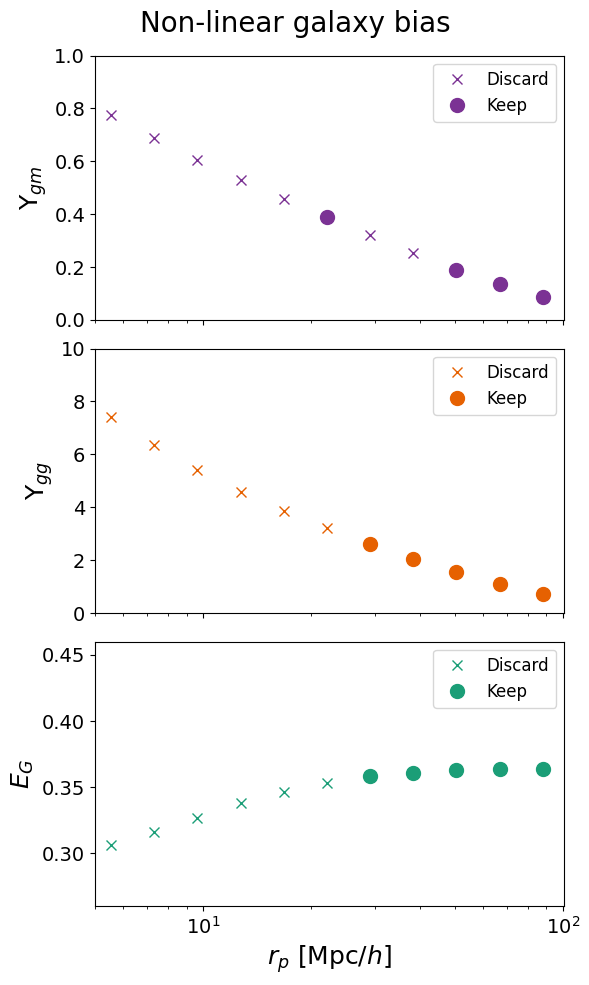

In [19]:

purple = '#7B3294'  # Upsilon_gm
orange = '#E66101'  # Upsilon_gg
teal   = '#1B9E77'  # E_G


fig, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# --- Panel 1: Upsilon_gm ---
axes[0].semilogx(rp_bin_c, data_nl_jp[0:len(rp_bin_c)], 'x', color=purple, markersize=7, label='Discard')
axes[0].semilogx(rp_keep_gm, Ups_keep_gm, 'o', color=purple, markersize=10, label='Keep')
axes[0].set_ylabel(r'$\Upsilon_{gm}$', fontsize=18)
axes[0].legend(fontsize=12)
axes[0].tick_params(labelsize=14)
axes[0].set_xlim(5, rp_bin_edges[-1])
axes[0].set_ylim(0, 1)

# --- Panel 2: Upsilon_gg ---
axes[1].semilogx(rp_bin_c, data_nl_jp[len(rp_bin_c):2*len(rp_bin_c)], 'x', color=orange, markersize=7, label='Discard')
axes[1].semilogx(rp_keep_gg, Ups_keep_gg, 'o', color=orange, markersize=10, label='Keep')
axes[1].set_ylabel(r'$\Upsilon_{gg}$', fontsize=18)
axes[1].legend(fontsize=12)
axes[1].tick_params(labelsize=14)
axes[1].set_xlim(5, rp_bin_edges[-1])
axes[1].set_ylim(0, 10)

# --- Panel 3: E_G ---
axes[2].semilogx(rp_bin_c, data_nl_EG, 'x', color=teal, markersize=7, label='Discard')
axes[2].semilogx(rp_keep_Eg, Eg_keep, 'o', color=teal, markersize=10, label='Keep')
axes[2].set_ylabel(r'$E_G$', fontsize=18)
axes[2].set_xlabel(r'$r_p$ [Mpc$/h$]', fontsize=18)
axes[2].legend(fontsize=12)
axes[2].tick_params(labelsize=14)
axes[2].set_xlim(5, rp_bin_edges[-1])
axes[2].set_ylim(0.26, 0.46)

# --- Overall Title ---
fig.suptitle('Non-linear galaxy bias', fontsize=20, y=0.98)

plt.tight_layout(h_pad=0.7)
plt.savefig('../plots/nLbias_linear_cuts_GR_rpgte5.pdf')
plt.show()

In [18]:
# Check if the v1 version of the scale cuts actually does give a chi2<=1 when doing the cut more properly.

cut_EG_cov = np.delete(np.delete(Dcov_eg, cut_inds_Eg,axis=0),cut_inds_Eg,axis=1)
cut_EG_invcov = np.linalg.pinv(cut_EG_cov)
print('cut_EG_invcov=', cut_EG_invcov)
Eg_keep_lin = data_lin_EG[ind_keep_Eg]
delta_keep = Eg_keep - Eg_keep_lin
print('delta keep=', delta_keep)

chi2_eg_proper = np.dot(delta_keep, np.dot(cut_EG_invcov, delta_keep))
print('chi2 with v1 cut=', chi2_eg_proper)

cut_EG_invcov= [[ 125202.06501958 -128606.29448473   -3069.04900691    6862.99782975    3689.45017242   -1020.94751022]
 [-128606.29448473  267421.12726117 -149469.91733381   10783.93077262   10587.5306412    -5064.4483949 ]
 [  -3069.04900691 -149469.91733381  215467.6029004   -72575.21163344     433.39977782    5712.69037316]
 [   6862.99782975   10783.93077262  -72575.21163344   89941.9828391   -43933.0946901     6814.74779133]
 [   3689.45017242   10587.5306412      433.39977782  -43933.0946901    43461.70199089  -12104.01742626]
 [  -1020.94751022   -5064.4483949     5712.69037315    6814.74779133  -12104.01742626    5706.15422954]]
delta keep= [-3.90152130e-03 -1.79519498e-03 -5.99160836e-04  6.32652275e-06  2.60606873e-04  3.71351198e-04]
chi2 with v1 cut= 0.6984565916383918


Why does the nonlinear dip below the linear at intermediate scales? Edit: Figured this out, it's a physical feature due to the nonlinear impact from void growth at intermediate scales, see HMCode-2020 paper.

In [ ]:
wgg_lin = fid.wgg(params, rp_bin_c, lens, Pimax, endfilename, nonlin = False)
wgg_nonlin = fid.wgg(params, rp_bin_c, lens, Pimax, endfilename, nonlin = True)

In [ ]:
plt.figure()
plt.loglog(rp_bin_c, wgg_lin, 'mo', label='Linear, $w_{gg}$')
plt.loglog(rp_bin_c, wgg_nonlin, 'go', label='Nonlinear, $w_{gg}$')
plt.legend()
plt.savefig('../plots/wgg_lin_vs_nonlin_1000_Pimax200.pdf')
plt.show()

In [ ]:
k_lin, Pkgg_lin = np.loadtxt('../txtfiles/Pkgg_nonlin=False.dat', unpack=True)
k_nl, Pkgg_nl = np.loadtxt('../txtfiles/Pkgg_nonlin=True.dat', unpack=True)

In [ ]:
plt.figure()
plt.loglog(k_lin, Pkgg_lin, 'm', label='Linear$')
plt.loglog(k_nl, Pkgg_nl, 'g', label='Nonlinear')
plt.xlim(10**(-3), 10**(-1))
plt.ylim(10**4, 5*10**5)
plt.legend()
#plt.savefig('../plots/wgg_lin_vs_nonlin_1000_Pimax200.pdf')
plt.show()

In [ ]:
plt.figure()
plt.semilogx(k_lin, Pkgg_nl/Pkgg_lin)
plt.ylim(0.9,1.1)
plt.show()